# Feb 17, 2025: community profile variability
- does a community look the same across modes, across animals? 
- how large is the stable/consistent set of rois per community?

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import jensenshannon, squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from multiprocessing import Pool
import glob
import random
from collections import Counter

from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

# import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [5]:
args.source ='allen' #'spatial' #'allen'
args.space = 'ccfv2' #'yale' #'ccfv2'
args.brain_div = 'whl' #'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [6]:
# relevant comms for plotting
if PARC_DESC == 'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200':
    args.relevant_comms = np.arange(0, 25)
    # args.relevant_comms = np.array([0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24])

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [8]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [9]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [10]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9943502824858758, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9082639088384565, 0.005617798206134892, 0....","[[0.8850912125784436, 0.09756830776993501, 0.0...","[[0.9881457547053836, 0.011854245294616511], [...","[[0.9952583018821535, 0.004741698117846605], [...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[1.0], [1.0], [1.0000000000000002], [1.0], [0...",0.177295,0
1,SLC01,sbm-nd-h,"[[0.9924242424242424, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9305555555555556, 0.0, 0.00751836547291092...","[[0.8583704854173055, 0.11905640763280642, 0.0...","[[0.9686317578785476, 0.03136824212145242], [0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.132086,1
2,SLC01,sbm-nd-h,"[[0.9672131147540983, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9002956194571352, 0.0, 0.00792797635044343...","[[0.8373335842458809, 0.11451218593710696, 0.0...","[[0.9879460856908309, 0.012053914309169156], [...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...",0.122464,2
3,SLC01,sbm-nd-h,"[[0.989247311827957, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.9813851312290439, 0.0, 0.00011562030292519...","[[0.9137888107775382, 0.06490505861861601, 0.0...","[[0.9885271006993847, 0.011472899300615397], [...","[[0.997705420139877, 0.0022945798601230792], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.093199,3
4,SLC01,sbm-nd-h,"[[0.44565217391304346, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.9117334697438667, 0.028759166164648204, 0....","[[0.9033271327908874, 0.095322184980498, 0.000...","[[0.9909216966685239, 0.009078303331476], [0.9...","[[0.995460848334262, 0.004539151665738], [0.99...","[[0.995460848334262, 0.004539151665738], [0.99...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...",0.091858,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.02105398883751773, 0.00040523863029342963,...","[[0.9629751425533718, 0.0367510004382298, 0.00...","[[0.9914532557120393, 0.008546744287960418], [...","[[0.9982906511424077, 0.0017093488575920836], ...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...",0.233420,1
81,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9869606077218264,...","[[0.9629514024881322, 0.037048597511867884, 0....","[[0.9919459570626374, 0.008054042937362584], [...","[[0.9991945957062638, 0.0008054042937362584], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.226136,2
82,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.014634146341463415, 0.0, 0.0, 0.0, 0.0, 0....","[[0.9943370542744164, 0.0054487874864401434, 0...","[[0.9995046556830509, 0.000495344316949104], [...","[[0.9997523278415255, 0.000247672158474552], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",

In [11]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0_aligned',
 'pi_1_aligned',
 'pi_2_aligned',
 'pi_3_aligned',
 'pi_4_aligned',
 'pi_5_aligned',
 'pi_6_aligned',
 'pi_7_aligned',
 'pi_8_aligned']

In [12]:
# SOFT MARGINALS
soft_marginals_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        SCs = np.average(M, axis=1, weights=omegas) # soft-comms.
        dct[col] = [SCs]
    soft_marginals_df += [pd.DataFrame(dct)]
soft_marginals_df = pd.concat(soft_marginals_df).reset_index(drop=True)
soft_marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,SLC01,sbm-nd-h,"[[0.8350398449216047, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9234274889601847, 0.008287321957659214, 0....","[[0.8908702470184068, 0.08818526539355183, 0.0...","[[0.9857811459804512, 0.014218854019548918], [...","[[0.9981012705398692, 0.0018987294601308003], ...","[[0.9991627001468633, 0.00083729985313675], [0...","[[0.9995796592276608, 0.00042034077233921245],...","[[0.9995796592276608, 0.00042034077233921245],...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
1,SLC03,sbm-nd-h,"[[0.9959974937418187, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6768468466157694, 0.0, 0.0, 0.000815961576...","[[0.6148675169749699, 0.3221452513143527, 0.05...","[[0.942766642829196, 0.05646330523768428, 0.0,...","[[0.9915518481163097, 0.008448151883690346], [...","[[0.9988453049018969, 0.001154695098103076], [...","[[0.9994090363311534, 0.0005909636688465277], ...","[[1.0], [1.0], [1.0], [1.0], [0.99999999999999...","[[1.0], [1.0], [1.0], [1.0], [0.99999999999999..."
2,SLC04,sbm-nd-h,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.05787139041183583, 0.2220399886622389, 0.0...","[[0.8400137502531448, 0.1527508895880438, 0.00...","[[0.9785607086546988, 0.021439291345301155], [...","[[0.9973152239931397, 0.002684776006860393], [...","[[0.9994691965126362, 0.0005308034873637976], ...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1..."
3,SLC05,sbm-nd-h,"[[0.0, 0.0, 0.9889917418684232, 0.0, 0.0, 0.0,...","[[0.028834487896569207, 0.08718234531258105, 0...","[[0.8784914810037195, 0.11490755272373639, 0.0...","[[0.980176979896686, 0.019554218911580833, 0.0...","[[0.996791006602236, 0.003208993397764034], [0...","[[0.9995367714396906, 0.00046322856030933885],...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
4,SLC06,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.002, 0.001, 0.007, 0.0, 0.0, 0.006, 0.0, 0...","[[0.9089495798228686, 0.06801941144612227, 0.0...","[[0.9852395439714076, 0.014572839840976206, 0....","[[0.998075285304022, 0.0019247146959779895], [...","[[1.0], [1.0], [1.0], [1.0], [0.99999999999999...","[[1.0], [1.0], [1.0], [1.0], [0.99999999999999...","[[1.0], [1.0], [1.0], [1.0], [0.99999999999999...","[[1.0], [1.0], [1.0], [1.0], [0.99999999999999..."
5,SLC07,sbm-nd-h,"[[0.0010014701352969006, 0.0, 0.0, 0.0, 0.0, 0...","[[0.013942758194564038, 0.01695420839259709, 0...","[[0.8499023686945077, 0.14879663332948065, 0.0...","[[0.9804523872297086, 0.01954761277029128, 0.0...","[[0.9950132837476334, 0.004986716252366397], [...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1..."
6,SLC08,sbm-nd-h,"[[0.046888069269248524, 0.0, 0.0, 0.0, 0.0, 0....","[[0.05950571050096976, 0.014454764327550393, 0...","[[0.8823427100644686, 0.09061210502248487, 0.0...","[[0.9827420553254071, 0.01676607759205636, 0.0...","[[0.9982984425441206, 0.0017015574558790886], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,SLC09,sbm-nd-h,"[[0.007968932875029262, 0.0, 0.0, 0.0, 0.0, 0....","[[0.05227932724229413, 8.520539865058172e-05, ...","[[0.9264292479627073, 0.06526048919926435, 0.0...","[[0.9901423943704234, 0.009768091992134261, 0....","[[0.9985564889397543, 0.0014435110602457498], ...","[[1.0], [1.0000000000000004], [1.0000000000000...","[[1.0], [1.0000000000000004], [1.0000000000000...","[[1.0], [1.0000000000000004], [1.0000000000000...","[[1.0], [1.0000000000000004], [1.000000000000

effective number of modes

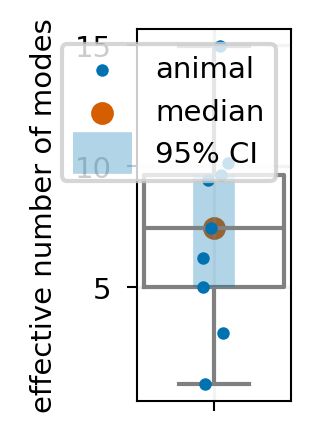

In [13]:
def compute_effective_number(probs):
    return np.exp(stats.entropy(probs))

E_ms = []
for key, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_numpy()
    E_m = compute_effective_number(omegas)
    E_ms += [E_m]
    # break

def bootstrap(values, stat=np.median, n_boot=100):
    boot_stats = [stat(resample(values)) for _ in range(n_boot)]
    return stat(values), np.percentile(boot_stats, [2.5, 97.5])

mean, (cil, ciu) = bootstrap(E_ms)


fig, axs = plt.subplots(1, 1, figsize=(75/72.27, 120/72.27))
ax = axs
fig.tight_layout()
sns.stripplot(
    # data=df, 
    # x='comm', y='encs', 
    E_ms,
    ax=ax,
    alpha=1.0, color=CUD_COLORS[0], size=3,
    label='animal',
)
sns.boxplot(
    # data=df, 
    # x='comm', y='encs', 
    E_ms,
    ax=ax,
    color='grey', fill=False, showfliers=0,
)
ax.scatter(0, mean, s=20, c=CUD_COLORS[1], label='median')
ax.vlines(x=0, ymin=cil, ymax=ciu, linewidth=10, alpha=0.3, label='95% CI')

ax.set(ylabel=f'effective number of modes')
ax.grid(alpha=0.15)
ax.legend()

folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')
fig.savefig(f'{folder}/desc-eff-num-modes.svg', bbox_inches='tight', transparent=True)

unique configurations

In [14]:
def compute_distances(config_matrix):
    # config_matrix : num_modes x num_rois
    distances = pdist(config_matrix, metric='cityblock') # metric='cosine'
    # distances /= np.max(distances) # normalize distances
    # distances /= config_matrix.shape[1] # num_modes
    distances = np.nan_to_num(distances)
    dist_matrix = squareform(distances)
    return dist_matrix, distances

def perform_hierarchical_clustering(dist_matrix, threshold=0.1):
    distances = squareform(dist_matrix)
    num_points = dist_matrix.shape[0]

    if not len(distances) > 0: return None, np.array([1])
    
    if num_points == 1:
        best_k = 1
        clusters = np.ones(1, dtype=int)
        return None, clusters, {}

    Z = linkage(distances, method='average')

    if num_points == 2:
        if dist_matrix[0, 1] < threshold:
            best_k = 1
            clusters = np.ones(2, dtype=int)
        else:
            best_k = 2
            clusters = np.array([1, 2], dtype=int)
        return Z, clusters, {}

    silhuette_scores = {}
    best_score = -1
    best_k = 1
    for k in range(2, num_points+1):
        labels = fcluster(Z, k, criterion='maxclust')
        try:
            score = silhouette_score(dist_matrix, labels, metric='precomputed')
            silhuette_scores[k] = score
            if score > best_score:
                best_score = score
                best_k = k
        except:
            continue
    
    if best_score <= 0:
        best_k = 1
        clusters = np.ones(num_points, dtype=int) # single cluster
    else:
        clusters = fcluster(Z, best_k, criterion='maxclust')
    return Z, clusters, silhuette_scores

def relabel_clusters_by_weight(clusters, omegas):
    clusters = np.asarray(clusters)
    omegas = np.asarray(omegas)
    
    n_clusters = clusters.max() + 1
    cluster_weights = np.bincount(clusters, weights=omegas, minlength=n_clusters)
    
    # Sort clusters by decreasing total weight → new label: 0 for max weight
    sorted_clusters = np.argsort(-cluster_weights)
    relabel_map = {old: new for new, old in enumerate(sorted_clusters)}
    
    return np.array([relabel_map[c] for c in clusters])

def compute_cluster_probabilities(clusters, omegas):
    if len(omegas) > 1:
        return np.bincount(clusters, weights=omegas)
    else:
        return np.array([1.0])

def compute_effective_number_of_configs(probs):
    return np.exp(stats.entropy(probs))

def get_unique_configs(config_matrix, clusters):
    # encdr : num_modes x num_clusters
    encdr = OneHotEncoder(
        sparse_output=False,
    ).fit_transform(clusters.reshape(-1, 1))
    # mean configuration within each cluster, 
    # config_matrix.T : num_rois x num_modes
    # cluster_configs : num_rois x num_clusters (per comm)
    unique_configs =  np.round(
        config_matrix.T @ encdr / encdr.sum(axis=0),
        decimals=3,
    )
    return unique_configs

def sort_cluster_results(cluster_probs, unique_configs):
    sort_idx = np.argsort(cluster_probs)[::-1] # decreasing order
    sorted_probs = cluster_probs[sort_idx]
    sorted_configs = unique_configs[:, sort_idx]
    return sorted_probs, sorted_configs

def analyze_configs_per_comm(config_matrix, omegas, threshold=0.1):
    dist_mat, dists = compute_distances(config_matrix)
    Z, clusters, silhuette_scores = perform_hierarchical_clustering(dist_mat, threshold)
    clusters = relabel_clusters_by_weight(clusters, omegas)
    cluster_probs = compute_cluster_probabilities(clusters, omegas)
    eff_num_configs = compute_effective_number_of_configs(cluster_probs)
    unique_configs = get_unique_configs(config_matrix, clusters)
    # cluster_probs, unique_configs = sort_cluster_results(cluster_probs, unique_configs)

    return (
        clusters, 
        eff_num_configs,
        cluster_probs,
        unique_configs,
        dist_mat,
        silhuette_scores,
    )

def analyze_configs_per_col(args, sub, SBM, col, M, omegas, threshold=0.1):  
    num_rois, num_modes, num_comms = M.shape
    col_df = []
    for comm in range(num_comms):
        (
            clusters,
            eff_num_configs, 
            cluster_strengths, 
            unique_configs,
            dist_mat,
            silhuette_scores,
        ) = analyze_configs_per_comm(M[:, :, comm].T, omegas, threshold=threshold)
        crow = pd.DataFrame(dict(
            sub=[sub],
            sbm=[SBM],
            col=[col],
            comm=[comm],
            clusters=[clusters],
            eff_num_configs=[eff_num_configs],
            strengths=[cluster_strengths],
            configs=[unique_configs],
            distance_matrix=[dist_mat],
            silhuette_scores=[silhuette_scores],
        ))
        col_df += [crow]
    col_df = pd.concat(col_df).reset_index(drop=True)
    return col_df

def analyze_configs_per_sub(args, sub, SBM, cols, group, threshold=0.1):
    configs_sub_df = []
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col)
        omegas = group['omega'].to_numpy()
        col_df = analyze_configs_per_col(args, sub, SBM, col, M, omegas, threshold=threshold)
        configs_sub_df += [col_df]
    return pd.concat(configs_sub_df).reset_index(drop=True)

In [15]:
probs = [0.83, 0.10, 0.07]
compute_effective_number_of_configs(probs), np.sum(probs)

(1.7701428716661645, 1.0)

In [16]:
(1.5 + 2.0)/2

1.75

In [17]:
analysis_df = []
threshold = 0.05 # threshold based on eff_num of amygdala (comm ??). 0.3 for source-spatial, and 0.1 for source-allen
for sub, group in tqdm(marginals_df.groupby('sub')):
    # display(group)
    if len(group) == 1: continue
    analysis_df += [analyze_configs_per_sub(args, sub, SBM, cols, group, threshold)]
analysis_df = pd.concat(analysis_df).reset_index(drop=True)

100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


In [18]:
analysis_df

,sub,sbm,col,comm,clusters,eff_num_configs,strengths,configs,distance_matrix,silhuette_scores
0,SLC01,sbm-nd-h,pi_0_aligned,0,"[0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0]",2.400761,"[0.6571514302860573, 0.19993998799759952, 0.14...","[[0.992, 0.658, 0.34], [0.0, 0.0, 0.0], [0.0, ...","[[0.0, 0.0888546481766821, 0.3562563675094937,...","{2: 0.60650431383196, 3: 0.7172743448274597, 4..."
1,SLC01,sbm-nd-h,pi_0_aligned,1,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]",1.518141,"[0.852990598119624, 0.14700940188037606]","[[0.0, 0.0], [0.999, 1.0], [0.0, 0.0], [1.0, 1...","[[0.0, 0.5256805341551103, 0.5867833657497454,...","{2: 0.7449646696225548, 3: 0.6710817337542371,..."
2,SLC01,sbm-nd-h,pi_0_aligned,2,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]",1.518141,"[0.852990598119624, 0.14700940188037606]","[[0.0, 0.0], [0.0, 0.0], [0.977, 0.977], [0.0,...","[[0.0, 0.19093477144324594, 0.3789478558858942...","{2: 0.7344533862889526, 3: 0.6407202714684819,..."
3,SLC01,sbm-nd-h,pi_0_aligned,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1.230122,"[0.9470494098819764, 0.052950590118023604]","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.01694915254237285, 0.0333425951653236...","{2: 0.6725588758271509, 3: 0.5304772298245856,..."
4,SLC01,sbm-nd-h,pi_0_aligned,4,"[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]",1.704917,"[0.7747149429885977, 0.22528505701140228]","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.17103235747303536, 0.3850143558395852...","{2: 0.559718331066228, 3: 0.4009830504894522, ..."
...,...,...,...,...,...,...,...,...,...,...
560,SLC10,sbm-nd-h,pi_5_aligned,0,"[1, 0, 0, 0, 0, 0]",1.754128,"[0.7503301981188714, 0.24966980188112867]","[[1.0, 0.999], [1.0, 0.998], [1.0, 0.999], [1....","[[0.0, 0.22531915437332017, 0.2253191543733141...","{2: 0.8333333333332776, 3: 0.12010921793615098..."
561,SLC10,sbm-nd-h,pi_5_aligned,1,"[1, 0, 0, 0, 0, 0]",1.754128,"[0.7503301981188714, 0.24966980188112867]","[[0.0, 0.001], [0.0, 0.002], [0.0, 0.001], [0....","[[0.0, 0.22531915437332237, 0.2253191543733223...","{2: 0.8333333333333334, 3: 0.8333333333333334,..."
562,SLC10,sbm-nd-h,pi_6_aligned,0,"[1, 0, 0, 2, 3, 2]",3.369475,"[0.45955573344006406, 0.24966980188112867, 0.2...","[[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [...","[[0.0, 2.142730437526552e-14, 1.58761892521397...","{2: 0.1233099750014461, 3: 0.08668555036614195..."
563,SLC10,sbm-nd-h,pi_7_aligned,0,"[1, 0, 0, 2, 3, 2]",3.369475,"[0.45955573344006406, 0.24966980188112867, 0.2...","[[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [...","[[0.0, 2.142730437526552e-14, 1.58761892521397...","{2: 0.1233099750014461, 3: 0.08668555036614195..."


In [19]:
if args.sbm in ['h']:
    row = analysis_df[
        (analysis_df['col'] == 'pi_0_aligned') &
        (analysis_df['sub'] == 'SLC10') &
        (analysis_df['comm'] == 6)
    ]
    print(
        row['strengths'].to_list()[0], 
        row['silhuette_scores'].to_list()[0], 
        row['distance_matrix'].to_list()[0]
    )
    

[0.72743646 0.27256354] {2: 0.6822984134536635, 3: 0.3797834209577375, 4: 0.330724752320948, 5: 0.330724752320948, 6: 0.330724752320948} [[0.         0.81670386 1.02523894 0.76809756 0.81187302 0.27843478]
 [0.81670386 0.         0.32458506 0.19792735 0.27495061 0.9716365 ]
 [1.02523894 0.32458506 0.         0.35847183 0.28739992 1.07887649]
 [0.76809756 0.19792735 0.35847183 0.         0.31157569 0.90116649]
 [0.81187302 0.27495061 0.28739992 0.31157569 0.         0.90062112]
 [0.27843478 0.9716365  1.07887649 0.90116649 0.90062112 0.        ]]


In [20]:
for sub, group in analysis_df.groupby('sub'):
    if not sub == 'SLC04': continue
    df = group

relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]
df = df[df['col'] == 'pi_0_aligned']
df[df['comm'].isin(relevant_comms)][['comm', 'strengths']]

,comm,strengths
151,0,"[0.5109556177528989, 0.25927628948420633, 0.16..."
152,1,"[0.9854458216713315, 0.014554178328668533]"
154,3,"[0.5731507397041183, 0.349860055977609, 0.0769..."
155,4,"[0.7153938424630149, 0.20761695321871249, 0.07..."
156,5,"[0.6501399440223911, 0.349860055977609]"
157,6,"[0.9173730507796882, 0.08262694922031187]"
159,8,"[0.9173730507796882, 0.08262694922031187]"
161,10,"[0.9445621751299481, 0.05543782487005198]"
162,11,"[0.9173730507796882, 0.08262694922031187]"
163,12,"[0.9173730507796882, 0.08262694922031187]"


rare form transitions. WHERE do the transitions happen: distributed or concentrated in a few modes?

In [21]:
rare_form_transitions_df = []
for (col, sub), group in analysis_df.groupby(by=['col', 'sub']):
    level = col.split('_')[1]
    level = -1 if level == 'aligned' else level
    if int(level) > 1: continue
    if int(level) == 0:
        relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]
    else:
        relevant_comms = args.relevant_comms
    group = group[group['comm'].isin(relevant_comms)]

    comm_clusters = np.stack(group['clusters'].to_list()) # num_comms x num_modes
    num_rare_forms = np.sum(comm_clusters > 0, axis=0)
    mean_transitions = np.mean(num_rare_forms) 
    median_transitions = np.median(num_rare_forms)
    
    row = dict(
        sub=sub,
        col=col,
        comm_clusters=comm_clusters,
        num_rare_transitions=num_rare_forms,
        mean=mean_transitions,
        median=median_transitions,
    )
    rare_form_transitions_df += [row]
rare_form_transitions_df = pd.DataFrame(rare_form_transitions_df)
rare_form_transitions_df

,sub,col,comm_clusters,num_rare_transitions,mean,median
0,SLC01,pi_0_aligned,"[[0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0], [0, 0, ...","[0, 1, 1, 2, 5, 7, 5, 3, 8, 5, 7, 5]",4.083333,5.0
1,SLC03,pi_0_aligned,"[[0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0...","[0, 0, 4, 6, 13]",4.600000,4.0
2,SLC04,pi_0_aligned,"[[0, 1, 2, 0, 0, 0, 1, 1, 2, 3, 3, 2, 0], [0, ...","[2, 3, 3, 3, 2, 2, 8, 3, 3, 5, 9, 6, 3]",4.000000,3.0
3,SLC05,pi_0_aligned,"[[1, 2, 0, 0, 3, 0, 0, 1, 0, 2, 2, 4], [2, 1, ...","[4, 5, 6, 6, 6, 3, 7, 6, 6, 6, 8, 10]",6.083333,6.0
4,SLC07,pi_0_aligned,"[[0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[1, 0, 2, 3, 6, 5, 2, 3]",2.750000,2.5
5,SLC08,pi_0_aligned,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,...","[2, 2, 3, 2, 1, 0, 0, 6, 4, 3, 3, 4, 5, 2, 4, ...",3.000000,3.0
6,SLC09,pi_0_aligned,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, ...","[0, 1, 2, 5, 1, 3, 6, 4, 1, 6]",2.900000,2.5
7,SLC10,pi_0_aligned,"[[1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1], [0, 0...","[7, 0, 0, 1, 3, 13]",4.000000,2.0
8,SLC01,pi_1_aligned,"[[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1], [0, 0, ...","[1, 3, 3, 10, 3, 6, 4, 6, 6, 3, 5, 7]",4.750000,4.5
9,SLC03,pi_1_aligned,"[[0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 1, 0...","[0, 2, 5, 3, 8]",3.600000,3.0


In [22]:
df = rare_form_transitions_df[rare_form_transitions_df['col'].isin([cols[0]])]
df

,sub,col,comm_clusters,num_rare_transitions,mean,median
0,SLC01,pi_0_aligned,"[[0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0], [0, 0, ...","[0, 1, 1, 2, 5, 7, 5, 3, 8, 5, 7, 5]",4.083333,5.0
1,SLC03,pi_0_aligned,"[[0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0...","[0, 0, 4, 6, 13]",4.600000,4.0
2,SLC04,pi_0_aligned,"[[0, 1, 2, 0, 0, 0, 1, 1, 2, 3, 3, 2, 0], [0, ...","[2, 3, 3, 3, 2, 2, 8, 3, 3, 5, 9, 6, 3]",4.000000,3.0
3,SLC05,pi_0_aligned,"[[1, 2, 0, 0, 3, 0, 0, 1, 0, 2, 2, 4], [2, 1, ...","[4, 5, 6, 6, 6, 3, 7, 6, 6, 6, 8, 10]",6.083333,6.0
4,SLC07,pi_0_aligned,"[[0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[1, 0, 2, 3, 6, 5, 2, 3]",2.750000,2.5
5,SLC08,pi_0_aligned,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,...","[2, 2, 3, 2, 1, 0, 0, 6, 4, 3, 3, 4, 5, 2, 4, ...",3.000000,3.0
6,SLC09,pi_0_aligned,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, ...","[0, 1, 2, 5, 1, 3, 6, 4, 1, 6]",2.900000,2.5
7,SLC10,pi_0_aligned,"[[1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1], [0, 0...","[7, 0, 0, 1, 3, 13]",4.000000,2.0


In [23]:
for idx, row in df.iterrows():
    level = row['col'].split('_')[1]
    level = -1 if level == 'aligned' else level
    if int(level) > 0: continue
    sub = row['sub']
    clusters = row['comm_clusters']
    
    folder = (
        f'{ESTIM_path}/individual/sub-{sub}/community-configurations/{SBM}'
    )
    os.makedirs(folder, exist_ok=True)
    np.savetxt(f'{folder}/desc-comm-clusters.txt', clusters, fmt='%.1f')
    # break

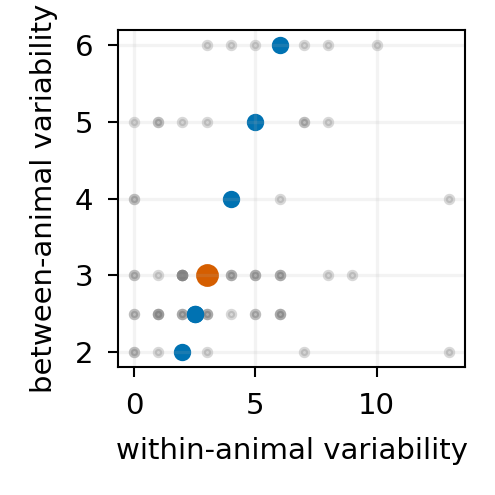

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(120/72.27, 120/72.27))  # ~ 3.23 x 2.46 in
ax = axs

for _, row in df.iterrows():
    sub = row['sub']
    y = row['median']
    x_vals = row['num_rare_transitions']
    ax.scatter(x_vals, [y] * len(x_vals), alpha=0.3, s=3, c='grey')
    ax.scatter(y, y, alpha=1.0, s=10, c=CUD_COLORS[0])

y = np.median(df['median'])
ax.scatter(y, y, s=20, c=CUD_COLORS[1])
ax.grid(alpha=0.15)
ax.set(
    xlabel=f'within-animal variability',
    ylabel=f'between-animal variability',
)
fig.tight_layout()

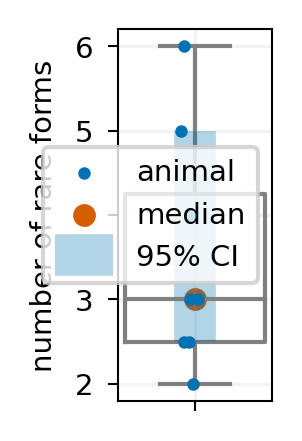

In [25]:
def bootstrap(values, stat=np.median, n_boot=100):
    boot_stats = [stat(resample(values)) for _ in range(n_boot)]
    return stat(values), np.percentile(boot_stats, [2.5, 97.5])

mean, (cil, ciu) = bootstrap(df['median'])

col = cols[0]
fig, axs = plt.subplots(1, 1, figsize=(75/72.27, 120/72.27))
ax = axs
fig.tight_layout()
sns.stripplot(
    data=df, 
    y='median',
    ax=ax,
    alpha=1.0, color=CUD_COLORS[0], size=3,
    label='animal',
)
sns.boxplot(
    data=df, 
    y='median',
    ax=ax,
    color='grey', fill=False, showfliers=0,
)
ax.scatter(0, mean, s=20, c=CUD_COLORS[1], label='median')
ax.vlines(x=0, ymin=cil, ymax=ciu, linewidth=10, alpha=0.3, label='95% CI')

ax.set(ylabel=f'number of rare forms')
ax.grid(alpha=0.15)
ax.legend()

folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')
fig.savefig(f'{folder}/{col}_desc-num-rare-transitions.svg', bbox_inches='tight', transparent=True)

In [26]:
# if args.sbm in ['h']:
#     ncols = 11 #len(analysis_df['sub'].unique())+1 #9
#     nrows = 24 #len(analysis_df['comm'].unique())
#     fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
#     fig.tight_layout(h_pad=3, w_pad=3)
#     for idx, row in tqdm(analysis_df.iterrows()):
#         if not row['col'] == 'pi_0_aligned': continue
#         r = row['comm']
#         if r > nrows-1 : continue
#         c = int(row['sub'][-2:]) #% ncols
#         D = row['distance_matrix']
        
#         ax = axs[r, c] if nrows > 1 else axs[c]
#         sns.heatmap(D, ax=ax, square=True, cmap=cc.cm.CET_L12)
#         ax.set(title=f'{row["sub"]}', ylabel=f'comm: {row["comm"]:02d}\nmodes', xlabel=f'modes')
#         # break

#     folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
#     os.system(f'mkdir -p {folder}')
#     fig.savefig(f'{folder}/desc-distance-matrices.pdf', bbox_inches='tight')
#     plt.close('all')

group statistics

In [27]:
def bootstrap_ci(data, statistic=np.median, n_boot=10000, conf=0.95):
    boots = [statistic(np.random.choice(data, len(data), replace=True)) 
             for _ in range(n_boot)]
    mean = statistic(data)
    ci = np.percentile(boots, [(1-conf)*50, (1+conf)*50])
    return mean, ci

In [28]:
group_df = []
for (col, comm), group in tqdm(analysis_df.groupby(by=['col', 'comm'])):
    # if (not col == 'pi_0') | (not comm == 2): continue
    encs = group['eff_num_configs'].to_list()
    m, ci = bootstrap_ci(encs, np.median)
    Ss = get_membership_matrix(1, group, 'strengths')
    Ss = Ss[0, :, :]
    Cs = get_membership_matrix(args.num_rois, group, 'configs')
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        comm=[comm],
        encs=[encs],
        mean=[m],
        cil=[ci[0]],
        ciu=[ci[1]],
        strengths=[Ss],
        configs=[Cs],
    ))
    group_df += [row]
group_df = pd.concat(group_df).reset_index(drop=True)

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:28<00:00,  2.95it/s]


In [29]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')
with open(f'{folder}/desc-group-df.pkl', 'wb') as f:
    pickle.dump([group_df], f)

In [30]:
group_df

,sbm,col,comm,encs,mean,cil,ciu,strengths,configs
0,sbm-nd-h,pi_0_aligned,0,"[2.4007610547801335, 1.0002364666067989, 3.200...",1.615249,1.286483,3.200696,"[[0.6571514302860573, 0.19993998799759952, 0.1...","[[[0.992, 0.658, 0.34, 0.0, 0.0], [0.998, 1.0,..."
1,sbm-nd-h,pi_0_aligned,1,"[1.5181406446141363, 1.2571068538394503, 1.078...",1.213995,1.115270,1.518141,"[[0.852990598119624, 0.14700940188037606, 0.0]...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,sbm-nd-h,pi_0_aligned,2,"[1.5181406446141363, 1.5757525170056372, 1.979...",1.546947,1.269155,1.979659,"[[0.852990598119624, 0.14700940188037606, 0.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0..."
3,sbm-nd-h,pi_0_aligned,3,"[1.230121681997618, 1.0002364666067989, 2.4202...",1.200517,1.066795,1.759598,"[[0.9470494098819764, 0.052950590118023604, 0....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,sbm-nd-h,pi_0_aligned,4,"[1.7049165336546717, 1.5757525170056372, 2.145...",1.696256,1.438426,2.145548,"[[0.7747149429885977, 0.22528505701140228, 0.0...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...
80,sbm-nd-h,pi_6_aligned,0,"[1.595628315848593, 1.9962297155512894, 1.3117...",1.323237,1.280786,1.996230,"[[0.8227045409081816, 0.17729545909181837, 0.0...","[[[1.0, 0.998, 0.0, 0.0], [1.0, 0.999, 0.0, 0...."
81,sbm-nd-h,pi_6_aligned,1,"[1.595628315848593, 1.9962297155512894]",1.795929,1.595628,1.996230,"[[0.8227045409081816, 0.17729545909181837], [0...","[[[0.0, 0.002], [0.0, 0.001]], [[0.0, 0.003], ..."
82,sbm-nd-h,pi_7_aligned,0,"[1.595628315848593, 1.923653890592859, 1.31173...",1.323237,1.280786,1.923654,"[[0.8227045409081816, 0.17729545909181837, 0.0...","[[[1.0, 0.998, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0]..."
83,sbm-nd-h,pi_7_aligned,1,[1.595628315848593],1.595628,1.595628,1.595628,"[[0.8227045409081816, 0.17729545909181837]]","[[[0.0, 0.002]], [[0.0, 0.003]], [[0.0, 0.003]..."


eff num configs. HOW many forms does a comm. adopt?

In [31]:
def plot_eff_num_configs(group, SBM, col, relevant_comms):
    fig, axs = plt.subplots(1, 1, figsize=(260/72.27, 178/72.27))  # ~ 3.23 x 2.46 in
    ax = axs

    df = group[['comm', 'encs']].explode('encs')
    sns.stripplot(
        data=df, 
        x='comm', y='encs', ax=ax,
        alpha=0.5, color=CUD_COLORS[0], size=3,
        jitter=False,
    )
    sns.boxplot(
        data=df, 
        x='comm', y='encs', ax=ax,
        color='grey', fill=False, showfliers=0,
    )
    
    indiv_vals = np.stack(group['encs'].to_list())
    ax.plot(indiv_vals, c='grey', linewidth=0.5, alpha=0.3)
    ax.plot(indiv_vals[:, 2], c='grey', linewidth=0.5, alpha=0.3, label='animal')
    # ax.plot(indiv_vals[:, 2], c=CUD_COLORS[7], linewidth=0.5, alpha=1.0, label='animal')
    # ax.plot(indiv_vals[:, 3], c=CUD_COLORS[3], linewidth=0.5, alpha=1.0, label='animal (ii)')

    ax.scatter(
        range(len(group)), group['mean'], 
        c=CUD_COLORS[1], marker='o', s=10, label='median'
    )
    ax.vlines(
        range(len(group)), 
        group['cil'], group['ciu'], 
        color=CUD_COLORS[0], 
        linewidth=5, alpha=0.3, label='95% CI'
    )
    
    bands = [
        (1.00, 1.25, '#88CCEE', '1.0'),
        (1.25, 1.75, '#F0E442', '1.5'),
        (1.75, 2.25, '#E69F00', '2.0'),
        (2.25, 2.75, '#D55E00', '2.5'),
        (2.75, 3.35, '#A00000', '3.0+'),
    ]
    
    for y1, y2, color, label in bands:
        ax.fill_between(
            x=np.arange(-0.5, len(group) + 0.5),
            y1=y1, y2=y2,
            color=color,
            alpha=0.15,
            label=label
        )

    ax.set(ylabel=f'', xlabel=f'', title=f'')
    ax.set_ylim(bottom=1.0, top=3.5)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    # ax.set_xticklabels([f'{i:02d}' for i in range(len(group))])
    ax.set_xticklabels([f'{i:02d}' for i in relevant_comms], rotation=90)
    # ax.set(ylabel=f'effective #configurations', xlim=[-0.65, len(group)], title=f'{SBM} {col}')
    ax.tick_params(axis='y', rotation=90)
    
    ax.grid(alpha=0.15)
    ax.legend()
    return fig

In [32]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')

for col, group in group_df.groupby('col'):
    level = col.split('_')[1]
    level = -1 if level == 'aligned' else level
    if int(level) > 0: continue
    if int(level) == 0:
        relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]
    else:
        relevant_comms = args.relevant_comms
    group = group[group['comm'].isin(relevant_comms)]
    fig = plot_eff_num_configs(group, SBM, col, relevant_comms)
    fig.savefig(f'{folder}/{col}_desc-eff-num-configs.svg', bbox_inches='tight')
    plt.close('all')

In [33]:
for col, group in group_df.groupby('col'):
    level = col.split('_')[1]
    level = -1 if level == 'aligned' else level
    if int(level) > 0: continue
    if int(level) == 0:
        relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]
    else:
        relevant_comms = args.relevant_comms
    group = group[group['comm'].isin(relevant_comms)]
    break
indiv_vals = np.stack(group['encs'].to_list())
np.sum(indiv_vals <= np.median(indiv_vals, axis=1)[:, None], axis=0)

array([ 3, 13,  6,  3, 12, 11,  8,  8])

In [34]:
# cluster_strengths

In [35]:
def plot_strengths(group, SBM, col):
    ncols = 7
    nrows = np.ceil(len(group) / ncols).astype(int)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharey=True)
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
    for idx_comm, row in group.iterrows():
        r, c = idx_comm // ncols, idx_comm % ncols
        ax = axs[r, c] if nrows > 1 else axs[c]

        sns.barplot(row['strengths'], ax=ax, color='grey', alpha=0.3)
        sns.stripplot(row['strengths'], ax=ax, color='cornflowerblue')
        ax.set(title=f'comm {idx_comm:02d}', xlabel=f'configuration', ylabel=f'strength')
        ax.grid(alpha=0.2)

    for c_ in np.arange(c+1, ncols):
        ax = axs[r, c_] if nrows > 1 else axs[c_]
        fig.delaxes(ax)

    return fig

In [36]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')

for col, group in group_df.groupby('col'):
    group = group[group['comm'].isin(args.relevant_comms)]
    level = col.split('_')[1]
    level = -1 if level == 'aligned' else level
    if int(level) > 1: continue
    group = group.reset_index(drop=True)
    fig = plot_strengths(group, SBM, col)
    fig.savefig(f'{folder}/{col}_desc-cluster-strengths.pdf', bbox_inches='tight')
    plt.close('all')

stable fracs. HOW different are the forms?

In [37]:
def get_stable_fraction_per_sub(strengths, configs, tol=0.01):
    comm_mask = ~np.all(configs <= tol, axis=1)
    comm_size = np.sum(comm_mask)
    diffs = np.abs(configs[comm_mask] - configs[comm_mask][:, [0]])
    weighted_diffs = diffs * strengths
    stable_frac = np.sum(np.all(weighted_diffs <= tol, axis=1)) / np.sum(comm_mask)
    return np.nan_to_num(stable_frac)

def get_stable_fracs_per_comm(Ss, Cs, tol=0.01):
    stable_fracs = []
    for sub in range(Ss.shape[0]):
        strengths = Ss[sub, :]
        configs = Cs[:, sub, :]
        stable_fracs.append(get_stable_fraction_per_sub(strengths, configs, tol))
    return np.array(stable_fracs)

def get_stable_fracs_per_col(group, tol=0.01):
    sfrac_df = []
    for idx_comm, row in group.iterrows():
        stable_fracs = get_stable_fracs_per_comm(
            row['strengths'],
            row['configs'],
            tol,
        )
        m, ci = bootstrap_ci(stable_fracs, )
        df = pd.DataFrame(dict(
            sbm=[SBM],
            col=[col],
            comm=[row['comm']],
            stable_fracs=[stable_fracs],
            mean=[m],
            cil=[ci[0]],
            ciu=[ci[1]],
        ))
        sfrac_df += [df]
    sfrac_df = pd.concat(sfrac_df).reset_index(drop=True)
    return sfrac_df

In [38]:
tol = 0.01
sfrac_df = []
for col, group in tqdm(group_df.groupby('col')):
    group = group[group['comm'].isin(args.relevant_comms)]
    group = group.reset_index(drop=True)
    col_df = get_stable_fracs_per_col(group, tol)
    sfrac_df += [col_df]
sfrac_df = pd.concat(sfrac_df).reset_index(drop=True)

100%|██████████| 9/9 [00:22<00:00,  2.55s/it]


In [39]:
sfrac_df

,sbm,col,comm,stable_fracs,mean,cil,ciu
0,sbm-nd-h,pi_0_aligned,0,"[0.45454545454545453, 1.0, 0.6923076923076923,...",0.692308,0.454545,0.909091
1,sbm-nd-h,pi_0_aligned,1,"[0.7777777777777778, 0.5714285714285714, 0.692...",0.735043,0.571429,1.000000
2,sbm-nd-h,pi_0_aligned,2,"[0.5, 0.3333333333333333, 0.6428571428571429, ...",0.644958,0.333333,0.714286
3,sbm-nd-h,pi_0_aligned,3,"[0.9166666666666666, 1.0, 0.35714285714285715,...",0.922619,0.357143,0.964286
4,sbm-nd-h,pi_0_aligned,4,"[0.8461538461538461, 0.4117647058823529, 0.818...",0.722222,0.428571,0.846154
...,...,...,...,...,...,...,...
65,sbm-nd-h,pi_6_aligned,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.000000,1.000000
66,sbm-nd-h,pi_6_aligned,1,"[0.0, 0.0]",0.000000,0.000000,0.000000
67,sbm-nd-h,pi_7_aligned,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,1.000000,1.000000
68,sbm-nd-h,pi_7_aligned,1,[0.0],0.000000,0.000000,0.000000


In [40]:
def plot_stable_fracs(group, SBM, col, relevant_comms):
    fig, axs = plt.subplots(1, 1, figsize=(260/72.27, 178/72.27))  # ~ 3.23 x 2.46 in
    ax = axs

    df = group[['comm', 'stable_fracs']].explode('stable_fracs')
    sns.stripplot(
        data=df, 
        x='comm', y='stable_fracs', ax=ax,
        alpha=0.5, color=CUD_COLORS[0], size=3,
        jitter=False,
    )
    sns.boxplot(
        data=df, 
        x='comm', y='stable_fracs', ax=ax,
        color='grey', fill=False, showfliers=0,
    )
    
    indiv_vals = np.stack(group['stable_fracs'].to_list())
    ax.plot(indiv_vals, c='grey', linewidth=0.5, alpha=0.3)
    ax.plot(indiv_vals[:, 2], c='grey', linewidth=0.5, alpha=0.3, label='animal')
    # ax.plot(indiv_vals[:, 2], c=CUD_COLORS[7], linewidth=0.5, alpha=1.0, label='animal')
    # ax.plot(indiv_vals[:, 3], c=CUD_COLORS[3], linewidth=0.5, alpha=1.0, label='animal (ii)')

    ax.scatter(
        range(len(group)), group['mean'], 
        c=CUD_COLORS[1], marker='o', s=10, label='median'
    )
    ax.vlines(
        range(len(group)), group['cil'], group['ciu'], 
        color=CUD_COLORS[0], linewidth=5, alpha=0.3, label='95% CI'
    )

    bands = [
        (0.00, 0.25, '#D55E00', ),
        (0.25, 0.50, '#E69F00', ),
        (0.50, 0.75, '#F0E442', ),
        (0.75, 1.00, '#88CCEE', ),
        # (2.75, 3.35, '#A00000', '3.0+'),
    ]
        
    for y1, y2, color, in bands:
        ax.fill_between(
            x=np.arange(-0.5, len(group) + 0.5),
            y1=y1, y2=y2,
            color=color,
            alpha=0.15,
            # label=label
        )

    ax.set(ylabel=f'', xlabel=f'', title=f'')
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    # ax.set_xticklabels([f'{i:02d}' for i in range(len(group))])
    ax.set_xticklabels([f'{i:02d}' for i in relevant_comms], rotation=90)
    # ax.set(ylabel=f'effective #configurations', xlim=[-0.65, len(group)], title=f'{SBM} {col}')
    ax.tick_params(axis='y', rotation=90)
    
    ax.grid(alpha=0.15)
    ax.legend()
    return fig

In [41]:
folder = f'{ESTIM_path}/group/community-configurations/{SBM}'
os.system(f'mkdir -p {folder}')

for col, group in sfrac_df.groupby('col'):
    level = col.split('_')[1]
    level = -1 if level == 'aligned' else level
    if int(level) > 0: continue
    if int(level) == 0:
        relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]
    else:
        relevant_comms = args.relevant_comms
    group = group[group['comm'].isin(relevant_comms)]
    fig = plot_stable_fracs(group, SBM, col, relevant_comms)
    fig.savefig(f'{folder}/{col}_desc-stable-fracs.svg', bbox_inches='tight', transparent=True)
    plt.close('all')